## Import statements

In [1]:
import copy
import random
import time
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models

from util.dataset_util import DatasetUtil
from util.dataset_vgg_utk import ValDatasetVggUtk
from util.imagenet import Imagenet
from util.imagenet_utk import ImagenetUtk
from util.imagenet_vgg import ImagenetVgg

# Use CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using %s for training/validating the model" % device)

# setting up seeds for reproducibility
torch.manual_seed(0)


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


Using cuda:0 for training/validating the model


## Data Preprocessing

In [2]:
# Parameter settings for batching
BATCH_SIZE = 128
# 64 <= image_size <= 224
IMAGE_SIZE = 64
# 0 <= WORKER_COUNT
WORKER_COUNT = 7
# 1 <= NUMBER_OF_CLASSES <= 201
NUMBER_OF_CLASSES = 4
# 0 < TRAIN_IMAGE_COUNT <= 500
TRAIN_IMAGE_COUNT = 500
# True/False
shuffle = True

# Use this line if you're executing for the first time
# data_utility = DatasetUtil(base_dir="./datasets", total_class_count=10, img_size=64, train_img_count=500,
#                            vgg_download=True)
data_utility = DatasetUtil(base_dir="./datasets", total_class_count=NUMBER_OF_CLASSES, img_size=IMAGE_SIZE,
                           train_img_count=TRAIN_IMAGE_COUNT,
                           load_from_json=False)
data_utility.save_all_json()

imagenet_datasets = {'train': Imagenet(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE),
                     'val': Imagenet(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE, validation=True)}
imagenet_dataloaders = {'train': DataLoader(dataset=imagenet_datasets['train'], batch_size=BATCH_SIZE,
                                            shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker),
                        'val': DataLoader(dataset=imagenet_datasets['val'], batch_size=BATCH_SIZE,
                                          shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker)}

# Load data for Tiny ImageNet + UTKFace
utk_datasets = {'train': ImagenetUtk(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE),
                'val': ImagenetUtk(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE, validation=True)}
utk_dataloaders = {'train': DataLoader(dataset=utk_datasets['train'], batch_size=BATCH_SIZE,
                                       shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker),
                   'val': DataLoader(dataset=utk_datasets['val'], batch_size=BATCH_SIZE,
                                     shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker)}

# Load data for Tiny ImageNet + VGG
vgg_datasets = {'train': ImagenetVgg(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE),
                'val': ImagenetVgg(du=data_utility, base_dir="./datasets", image_size=IMAGE_SIZE, validation=True)}
vgg_dataloaders = {'train': DataLoader(dataset=vgg_datasets['train'], batch_size=BATCH_SIZE,
                                       shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker),
                   'val': DataLoader(dataset=vgg_datasets['val'], batch_size=BATCH_SIZE,
                                     shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker)}

utk_vgg_dataset = ValDatasetVggUtk(du=data_utility, image_size=IMAGE_SIZE)
utk_vgg_dataloader = DataLoader(dataset=utk_vgg_dataset, batch_size=BATCH_SIZE,
                                shuffle=shuffle, num_workers=WORKER_COUNT, worker_init_fn=seed_worker)


# this classes list will contain class names of items[0] to [9] in string
# class_names = utk_datasets['train'].get_class_names()

05/29/2021 08:53:26 PM - INFO: Resized images saved.
05/29/2021 08:53:26 PM - INFO: int2name saved as: ./datasets/modified_datasets/int2name.json
05/29/2021 08:53:26 PM - INFO: Tiny ImageNet id2int saved as: ./datasets/modified_datasets/imagenet/id2int.json
05/29/2021 08:53:26 PM - INFO: Tiny ImageNet id2name saved as: ./datasets/modified_datasets/imagenet/id2name.json
05/29/2021 08:53:26 PM - INFO: Tiny ImageNet training list saved as: ./datasets/modified_datasets/imagenet/train.json
05/29/2021 08:53:26 PM - INFO: Tiny ImageNet validation list saved as: ./datasets/modified_datasets/imagenet/validation.json
05/29/2021 08:53:26 PM - INFO: UTKFace training list saved as: ./datasets/modified_datasets/utk/train.json
05/29/2021 08:53:26 PM - INFO: UTKFace validation list saved as: ./datasets/modified_datasets/utk/validation.json
05/29/2021 08:53:26 PM - INFO: VGG training list saved as: ./datasets/modified_datasets/vgg/train.json
05/29/2021 08:53:26 PM - INFO: VGG validation list saved as: 

## Dataset preview

In [3]:
def info_data(image_datasets: dict, dataloaders: dict) -> None:
    """
    Prints info. about datasets/dataloaders; uncomment if necessary
    :return: None
    """
    cls = image_datasets["train"].get_class_names()
    print('Number of classes: %s' % len(cls))
    print('Class names: %s' % cls)
    print('Length of training dataset: %s' % len(image_datasets['train']))
    print('Length of validation dataset: %s' % len(image_datasets['val']))
    print('Batch size: %s' % BATCH_SIZE)
    print('Number of batches in the training dataloader: %s' % len(dataloaders['train']))
    print('Number of batches in the training dataloader: %s' % len(dataloaders['val']))
    print('Device: %s\n' % device)


print("Imagenet dataset statistics")
info_data(imagenet_datasets, imagenet_dataloaders)
print("UTKFace dataset statistics")
info_data(utk_datasets, utk_dataloaders)
print("VGG Face dataset statistics")
info_data(vgg_datasets, vgg_dataloaders)

Imagenet dataset statistics
Number of classes: 4
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'face']
Length of training dataset: 1500
Length of validation dataset: 150
Batch size: 128
Number of batches in the training dataloader: 12
Number of batches in the training dataloader: 2
Device: cuda:0

UTKFace dataset statistics
Number of classes: 4
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'face']
Length of training dataset: 2000
Length of validation dataset: 200
Batch size: 128
Number of batches in the training dataloader: 16
Number of batches in the training dataloader: 2
Device: cuda:0

VGG Face dataset statistics
Number of classes: 4
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'face']
Length of training dataset: 2000
Length of validation dataset: 200
Batch size: 128
Number of batches in the training dataloader: 16
Number of batches in the tr

In [4]:
def image_show(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


def get_preview(dataloaders: dict, title: str):
    """
    Preview 64 images in training dataset
    :param dataloaders: Dataloader dictionary to use to print images
    :param title: Title of the preview
    :return: None
    """
    # Get the first batch of training data
    inputs, classes = list(dataloaders['train'])[0]

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs[:64], normalize=True)

    image_show(out, title=title)

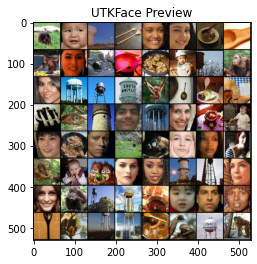

In [5]:
get_preview(dataloaders=utk_dataloaders, title="UTKFace Preview")

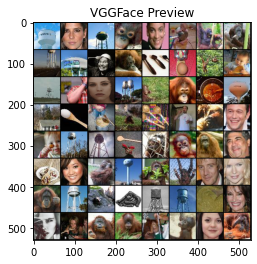

In [6]:
get_preview(dataloaders=vgg_dataloaders, title="VGGFace Preview")

## Model Training

In [7]:
# Parameters
EPOCH = 25
LEARNING_RATE = 0.001
SGD_MOMENTUM = 0.9
SGD_WEIGHT_DECAY = 0.0001
LR_DECAY_STEP_SIZE = 7
LR_DECAY_FACTOR = 0.1


def train_model(model_ft: Any, dataloaders, image_datasets):
    def _train_model(model: Any, criterion, optimizer, scheduler, dl, img_datasets):
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(EPOCH):
            print('Epoch {}/{}'.format(epoch, EPOCH - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for imgs, labels in dl[phase]:
                    # print('Iterating ', labels, '...')
                    torch.cuda.empty_cache()  # clean up cache
                    #print(torch.cuda.memory_summary(device=device, abbreviated=False))
                    imgs = imgs.float().to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(imgs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * imgs.size(0)
                    running_corrects += torch.eq(preds, labels.data).sum()
                if phase == 'train':
                    scheduler.step()
                dataset_size = len(img_datasets[phase])
                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                print('{} Loss: {:.4f} Acc: {:.4f}%'.format(
                    phase, epoch_loss, epoch_acc * 100))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model

    num_ftrs = model_ft.fc.in_features

    # TODO: Here the size of each output sample is set to 2 it is the number of classes.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, len(image_datasets['train'].get_class_names()))

    model_ft = model_ft.to(device)

    loss_fn = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, weight_decay=SGD_WEIGHT_DECAY,
                             momentum=SGD_MOMENTUM)

    # Decay LR by a factor of 0.1 every 7 epochs
    # TODO: Perhaps we can consider ReduceLROnPlateau instead
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=LR_DECAY_STEP_SIZE, gamma=LR_DECAY_FACTOR)

    return _train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                        dl=dataloaders, img_datasets=image_datasets)

# model_arch = models.resnet50()

In [8]:
imgnet_model_ft = train_model(models.resnet50(), dataloaders=imagenet_dataloaders, image_datasets=imagenet_datasets)

Epoch 0/24
----------
train Loss: 1.2655 Acc: 0.3273
val Loss: 1.1153 Acc: 0.4267

Epoch 1/24
----------
train Loss: 1.0917 Acc: 0.4020
val Loss: 1.3325 Acc: 0.4867

Epoch 2/24
----------
train Loss: 1.1292 Acc: 0.4093
val Loss: 1.3501 Acc: 0.3733

Epoch 3/24
----------
train Loss: 1.0189 Acc: 0.4940
val Loss: 1.1775 Acc: 0.5067

Epoch 4/24
----------
train Loss: 0.9628 Acc: 0.5413
val Loss: 1.0278 Acc: 0.5200

Epoch 5/24
----------
train Loss: 0.9462 Acc: 0.5513
val Loss: 0.9984 Acc: 0.5667

Epoch 6/24
----------
train Loss: 0.8556 Acc: 0.6313
val Loss: 0.8765 Acc: 0.6533

Epoch 7/24
----------
train Loss: 0.7982 Acc: 0.6573
val Loss: 0.8453 Acc: 0.5933

Epoch 8/24
----------
train Loss: 0.7698 Acc: 0.6700
val Loss: 0.7979 Acc: 0.6467

Epoch 9/24
----------
train Loss: 0.7730 Acc: 0.6720
val Loss: 0.8044 Acc: 0.6400

Epoch 10/24
----------
train Loss: 0.7694 Acc: 0.6853
val Loss: 0.8145 Acc: 0.6333

Epoch 11/24
----------
train Loss: 0.7346 Acc: 0.6893
val Loss: 0.8060 Acc: 0.6333

Ep

In [9]:
utk_model_ft = train_model(models.resnet50(), dataloaders=utk_dataloaders, image_datasets=utk_datasets)
# utk_model_ft = train_model(models.resnet50(), dataloaders=utk_dataloaders, image_datasets=utk_datasets)

Epoch 0/24
----------
train Loss: 1.4694 Acc: 0.3000
val Loss: 2.6808 Acc: 0.3000

Epoch 1/24
----------
train Loss: 1.4167 Acc: 0.3025
val Loss: 2.0766 Acc: 0.3350

Epoch 2/24
----------
train Loss: 1.3366 Acc: 0.3550
val Loss: 1.4053 Acc: 0.3900

Epoch 3/24
----------
train Loss: 1.2848 Acc: 0.4135
val Loss: 1.2812 Acc: 0.4600

Epoch 4/24
----------
train Loss: 1.1502 Acc: 0.5100
val Loss: 1.1236 Acc: 0.5600

Epoch 5/24
----------
train Loss: 1.0182 Acc: 0.6065
val Loss: 1.1511 Acc: 0.4900

Epoch 6/24
----------
train Loss: 0.9563 Acc: 0.6155
val Loss: 0.9802 Acc: 0.6000

Epoch 7/24
----------
train Loss: 0.8797 Acc: 0.6580
val Loss: 0.8844 Acc: 0.6400

Epoch 8/24
----------
train Loss: 0.8548 Acc: 0.6595
val Loss: 0.8496 Acc: 0.6400

Epoch 9/24
----------
train Loss: 0.8330 Acc: 0.6805
val Loss: 0.8576 Acc: 0.6400

Epoch 10/24
----------
train Loss: 0.8242 Acc: 0.6780
val Loss: 0.8307 Acc: 0.6750

Epoch 11/24
----------
train Loss: 0.7979 Acc: 0.6935
val Loss: 0.8528 Acc: 0.6800

Ep

In [10]:
vgg_model_ft = train_model(models.resnet50(), dataloaders=vgg_dataloaders, image_datasets=vgg_datasets)

Epoch 0/24
----------
train Loss: 1.4023 Acc: 0.3185
val Loss: 2.3209 Acc: 0.3300

Epoch 1/24
----------
train Loss: 1.3485 Acc: 0.3825
val Loss: 2.4332 Acc: 0.3950

Epoch 2/24
----------
train Loss: 1.2226 Acc: 0.4420
val Loss: 1.9920 Acc: 0.3900

Epoch 3/24
----------
train Loss: 1.1343 Acc: 0.4710
val Loss: 1.3523 Acc: 0.3500

Epoch 4/24
----------
train Loss: 1.0697 Acc: 0.5280
val Loss: 1.1277 Acc: 0.5050

Epoch 5/24
----------
train Loss: 1.0543 Acc: 0.5425
val Loss: 1.1179 Acc: 0.4650

Epoch 6/24
----------
train Loss: 0.9856 Acc: 0.5740
val Loss: 1.2336 Acc: 0.5350

Epoch 7/24
----------
train Loss: 0.9655 Acc: 0.5860
val Loss: 0.9932 Acc: 0.5450

Epoch 8/24
----------
train Loss: 0.9125 Acc: 0.6230
val Loss: 0.9898 Acc: 0.5450

Epoch 9/24
----------
train Loss: 0.9048 Acc: 0.6330
val Loss: 0.9784 Acc: 0.5700

Epoch 10/24
----------
train Loss: 0.8834 Acc: 0.6405
val Loss: 0.9832 Acc: 0.5400

Epoch 11/24
----------
train Loss: 0.8776 Acc: 0.6485
val Loss: 0.9656 Acc: 0.5700

Ep

## Model Visualization

In [31]:
def visualize_model(model, datasets: dict, dataloaders: dict, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(10,15), dpi=100)

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dataloaders['val']):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for j in range(imgs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                pred_str = datasets["train"].get_class_name(preds[j].item()).split(",")[0]
                gt_str = datasets["train"].get_class_name(labels.cpu().numpy()[images_so_far - 1]).split(",")[0]
                # TODO: Using .get_class_names() for actual prediction is discouraged as index may not be correct.
                ax.set_title(('P:%s   GT:%s' % (pred_str, gt_str)))
                image_show(imgs.int().cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

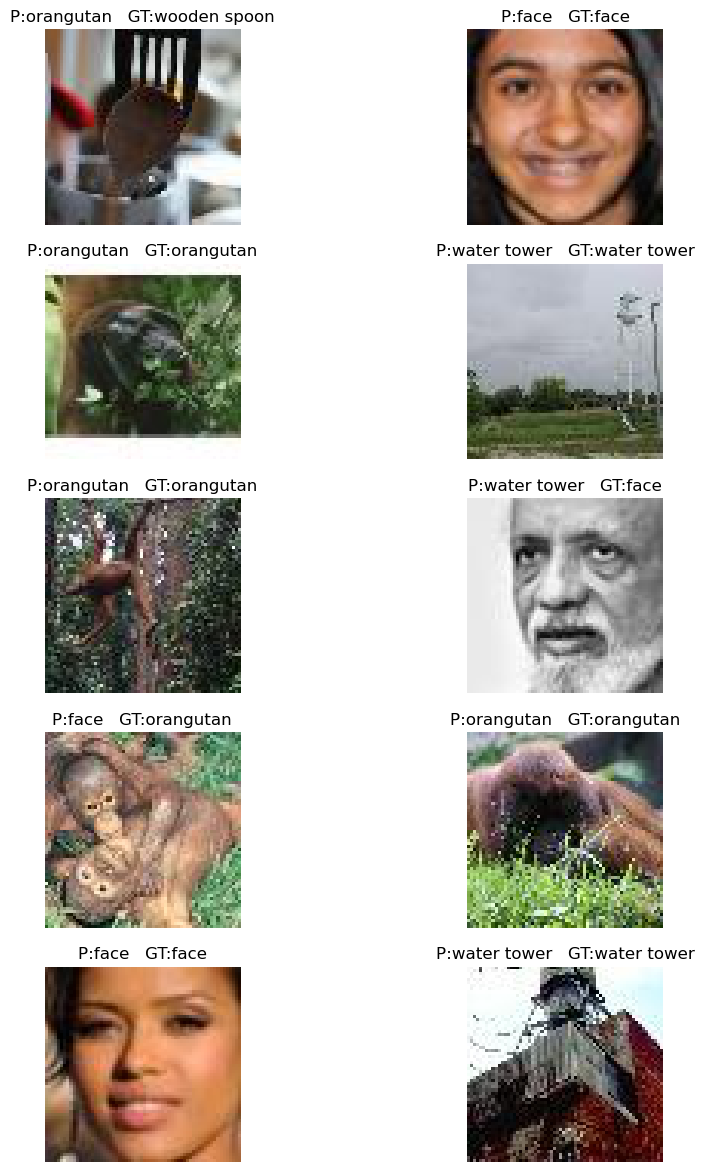

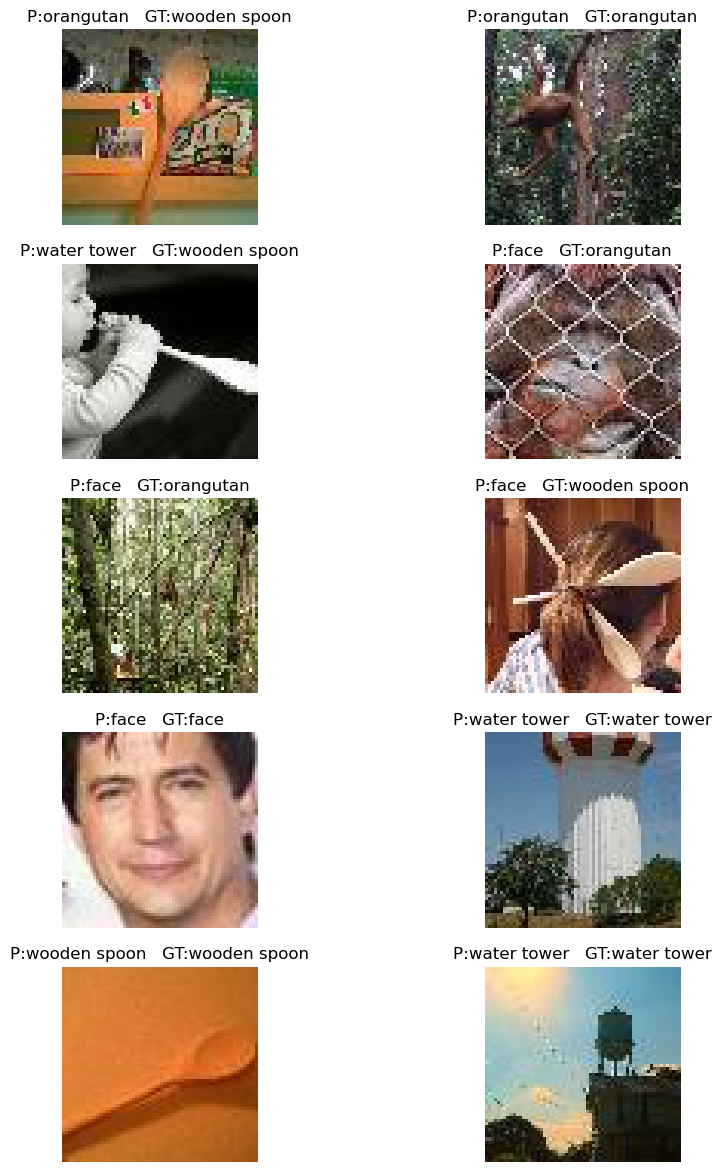

In [32]:
# Visualize utk models
visualize_model(utk_model_ft, utk_datasets, utk_dataloaders)
# Visualize vgg models
visualize_model(vgg_model_ft, vgg_datasets, vgg_dataloaders)